In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
cols_t = [r'$M_*$', r'$M_{cold}$', r'$Z_{gas}$', r'$SFR$', r'$SFR_{100}$', r'$M_{BH}$']

In [2]:
# this is the correlated run
folder = 'results_final_Z_270322'
run= 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_msdgfh_1_2'

folder = 'results_final_Z_300322'
run= 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_mllteo'

pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
ys, pred = results['low_ys'], results['low_pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2]+9, pred[:,2]+9
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

Zy-=Coldy
Zpred-=Coldpred

ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

In [3]:
# ys, pred = results['low_ys'], results['low_pred']

# mstar_ys, mstar_pred = ys[:,0], pred[:,0]
# Zy, Zpred = ys[:,2], pred[:,2]
# Coldy, Coldpred = ys[:,1], pred[:,1]
# sfr_ys, sfr_pred = ys[:,3], pred[:,3]
# sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
# Mbh_ys, Mbh_pred = ys[:,5], pred[:,5]
# Zy-=Coldy
# Zpred-=Coldpred

# ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
# pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

In [4]:
datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/vlarge_all_all_t_z0.0_None/data.pkl'), 'rb'))

In [5]:
from torch_geometric.data import Data
data=[]
for d in datat:
    if np.all(d.y.numpy()[np.arange(5,28)]>0):
        data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[8,15,20,21,23,27]]))
    else:
#         print(d.y.numpy()[np.arange(5,27)]>0)
        continue

In [6]:
testidx = pickle.load(open(osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage/tvt_idx/test_idx_rm.pkl'), 'rb'))

In [7]:
trainidx = np.arange(len(data))
trainidx = np.delete(trainidx, testidx)

In [8]:
Xte = []
Xtr = []
ytr = []
yte = []
test_data = []
for i, d in tqdm(enumerate(data), total=len(data)):
    if i in testidx:
        Xte.append(d.x.numpy()[0,:])
        yte.append(d.y.numpy())
        test_data.append(d.x.numpy())
    else:
        Xtr.append(d.x.numpy()[0,:])
        ytr.append(d.y.numpy())

100%|██████████████████████████████████████████████████████| 108338/108338 [03:50<00:00, 470.34it/s]


In [9]:
Xte = np.array(Xte)
Xtr = np.array(Xtr)
ytr = np.array(np.log10(ytr))
yte = np.array(np.log10(yte))

In [10]:
Mhf=[]
M200= []
M500 = []
M2500 = []
r_vir = []
rs_klypin = []
for d in test_data:
    Mhf.append(d[0,3])
    
    r_vir.append(d[0,4])
    rs_klypin.append(d[0,20])
    
    M200.append(d[0,23])
    M500.append(d[0,24])
    M2500.append(d[0,25])  
    

In [11]:
nbins=30
# edges=np.percentile(Mhf[Mhf>10.5], np.linspace(0,100,nbins))
edges=np.linspace(10, max(Mhf),nbins)
centers=(edges[:-1]+edges[1:])/2
sigM=[]
ysigs, predsigs = [], []
yb, predb = [], []
pillai_gnn = []
pillai_ys = []
pred1684, ys1684 = [], []

k=0

for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
    ysigs.append(np.std(yte[:,k][mask]))
    predsigs.append(np.std(pred[:,k][mask]))
    sigM.append(np.std(pred[:,k][mask]-ys[:,k][mask]))
    yb.append(np.mean(ys[:,k][mask]))
    predb.append(np.mean(pred[:,k][mask]))
    pillai_gnn.append((np.percentile(pred[:,k][mask], 84)-np.percentile(pred[:,k][mask], 16))/2)
    pillai_ys.append((np.percentile(ys[:,k][mask], 84)-np.percentile(ys[:,k][mask], 16))/2)
    pred1684.append(np.percentile(pred[:,k][mask], [16,84]))
    ys1684.append(np.percentile(ys[:,k][mask], [16,84]))
    
#     predb.append(np.mean(pred[mask]))
    
sigM=np.array(sigM)
ysigs, predsigs = np.array(ysigs), np.array(predsigs)
yb, predb = np.array(yb), np.array(predb)
ys1684, pred1684 = np.vstack(ys1684), np.vstack(pred1684)

/tmp/ipykernel_13873/743119264.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(ylim=(6,12), xlim=(10,13.5), xticklabels=[10,10.5,11,11.5,12,12.5,13],\
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


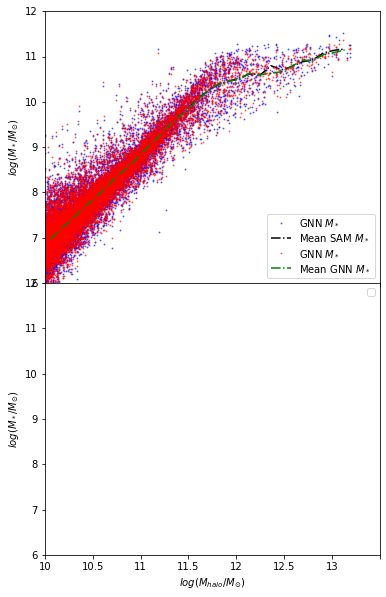

In [12]:
fig, ax = plt.subplots(2, figsize=(6,10), sharex=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
aplot, afill = 0.5, 0.6
ms = 1
fill = 0
cy, cpred = 'k', 'g'
# if not fill:
#     cy = cpred = 'k'

ax[0].plot(Mhf, ys[:,k], 'bo', markersize=ms, alpha=aplot, label = f'GNN {cols_t[k]}')
ax[0].plot(centers, yb, f'{cy}-.', label =f'Mean SAM {cols_t[k]}')
if fill:
    ax[0].fill_between(centers, ys1684[:,0], ys1684[:,1], color=f'{cy}', alpha=afill)

ax[0].plot(Mhf, pred[:,k], 'ro', markersize=ms, alpha=aplot, label = f'GNN {cols_t[k]}')
ax[0].plot(centers, predb, f'{cpred}-.', label =f'Mean GNN {cols_t[k]}')
if fill:
    ax[1].fill_between(centers, pred1684[:,0], pred1684[:,1], color=f'{cpred}', alpha=afill)

for a in ax:
    a.set(ylim=(6,12), xlim=(10,13.5), xticklabels=[10,10.5,11,11.5,12,12.5,13],\
         xlabel = r'$log(M_{halo}/M_{\odot})$')
    a.set(ylabel = r'$log(M_*/M_{\odot})$',)
    a.legend()

In [18]:
def agarwal_fig2(ks = [0,1,2,3,4,5], l=0.01, cy = 'k', cpred = 'g', nbins=25, fill = 0, ms=1, afill = 0.3, aplot = 0.7):
    
    fig, ax = plt.subplots(len(ks), 2, figsize=(15,30), sharex=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
    cy1, cpred1 = 'b', 'r'
    for k in ks:
        # edges=np.percentile(Mhf[Mhf>10.5], np.linspace(0,100,nbins))
        edges=np.linspace(10, max(Mhf),nbins)
        centers=(edges[:-1]+edges[1:])/2
        sigM=[]
        ysigs, predsigs = [], []
        yb, predb = [], []
        pillai_gnn = []
        pillai_ys = []
        pred1684, ys1684 = [], []

        for i in range(len(edges)-1):
            mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
            ysigs.append(np.std(yte[:,k][mask]))
            predsigs.append(np.std(pred[:,k][mask]))
            sigM.append(np.std(pred[:,k][mask]-ys[:,k][mask]))
            yb.append(np.median(ys[:,k][mask]))
            predb.append(np.median(pred[:,k][mask]))
            pillai_gnn.append((np.percentile(pred[:,k][mask], 84)-np.percentile(pred[:,k][mask], 16))/2)
            pillai_ys.append((np.percentile(ys[:,k][mask], 84)-np.percentile(ys[:,k][mask], 16))/2)
            pred1684.append(np.percentile(pred[:,k][mask], [16,84]))
            ys1684.append(np.percentile(ys[:,k][mask], [16,84]))

        #     predb.append(np.mean(pred[mask]))

        sigM=np.array(sigM)
        ysigs, predsigs = np.array(ysigs), np.array(predsigs)
        yb, predb = np.array(yb), np.array(predb)
        ys1684, pred1684 = np.vstack(ys1684), np.vstack(pred1684)

        ax[k][0].plot(Mhf, ys[:,k], 'bo', markersize=ms, alpha=aplot, label = f'SAM {cols_t[k]}')
        if fill:
            ax[k][1].plot(centers, yb, f'{cy}-.', label =f'Median SAM {cols_t[k]}')

        ax[k][0].plot(Mhf, pred[:,k], 'ro', markersize=ms, alpha=aplot, label = f'GNN {cols_t[k]}')
        if fill:
            ax[k][1].plot(centers, predb, f'{cpred}-', label =f'Median GNN {cols_t[k]}')
           
        
        if fill:
            ax[k][1].fill_between(centers, ys1684[:,0], ys1684[:,1], color=f'{cy1}', alpha=afill, label = f'16th/84th percentile SAM {cols_t[k]}')
            ax[k][1].fill_between(centers, pred1684[:,0], pred1684[:,1], color=f'{cpred1}', alpha=afill, label = f'16th/84th percentile GNN {cols_t[k]}')
                
            
        ax[k][0].plot(centers, yb, f'{cy}-.', label =f'Median SAM {cols_t[k]}')
        ax[k][0].plot(centers, predb, f'{cpred}-', label =f'Median GNN {cols_t[k]}')
        
        a = ax[k][0]
        a.set(ylim=np.percentile(np.hstack([pred[:,k], ys[:,k]]), [l,100-l])+np.array([-0.2,0.2]), xlim=(10,13.5))
        if k==max(ks):
             a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
             xlabel = r'$M_{halo}$')
        a.set(ylabel = f'{cols_t[k]}',)
        a.legend(fontsize = 12, loc = 'lower right')
        a = ax[k][1]
        a.set(ylim=np.percentile(np.hstack([pred[:,k], ys[:,k]]), [l,100-l])+np.array([-0.2,0.2]), xlim=(10,13.5))
        if k==max(ks):
            a.set(xticklabels=[10,11,12,13],\
             xlabel = r'$M_{halo}$')
        a.set(yticklabels=[])
        a.legend(fontsize = 12, loc = 'lower right')
    return fig

/tmp/ipykernel_13873/1799837634.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_13873/1799837634.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,11,12,13],\


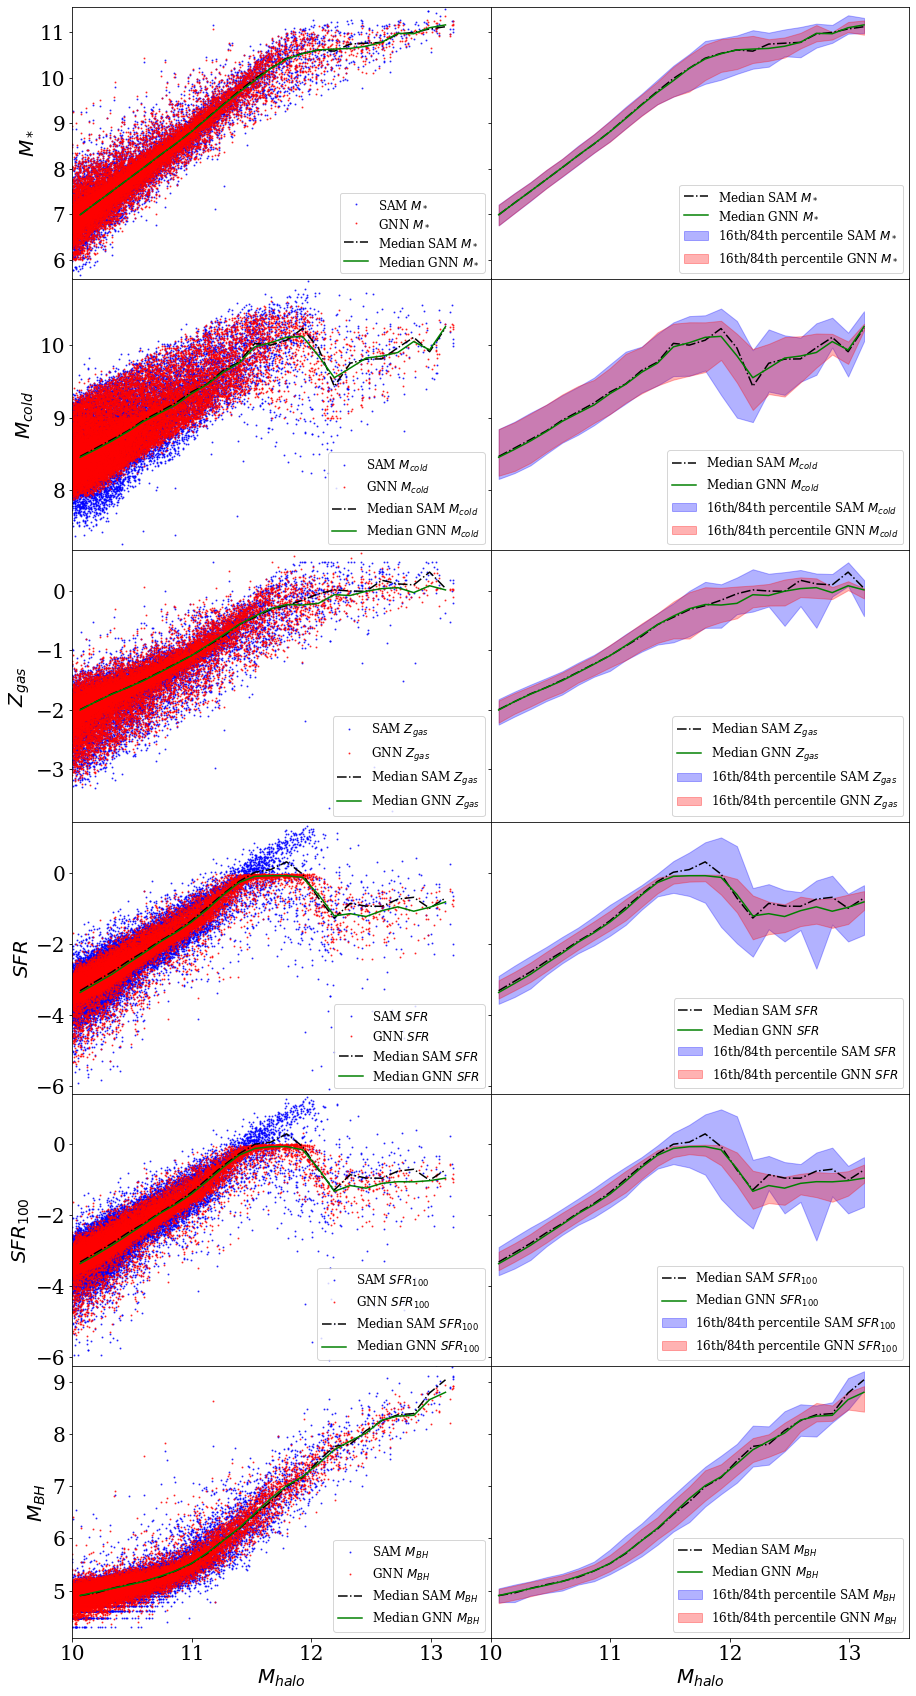

In [19]:
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)


fig=agarwal_fig2(fill=1)

In [21]:
fig.savefig('../paper_figures/agarwal_fig2.png')